In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
import numpy.ma as ma
import cartopy.crs as ccrs
from tqdm import tqdm_notebook as tqdm

import mplotutils as mpu
import cf_units
import cftime

In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
def linregress_grid(df,df_time,start,end):
    x,y=np.meshgrid(np.arange(72),np.arange(144))
    slope=np.zeros([72,144])
    i_start=np.where(df_time==start)[0][0]
    i_end=np.where(df_time==end)[0][0]
    
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        slope[i_x,i_y]=10*stats.linregress(np.arange(end-start+1),df[i_start:i_end+1,i_x,i_y])[0]
    return slope

def mean_trend_from_dict(df,df_time,start,end, roll=False):
    
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.mean(all_trends,axis=0),72,1)
    else:
        return np.mean(all_trends,axis=0)
    
def trend_dist_from_dict(df,df_time,start,end, roll=False):
    
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.quantile(all_trends,[0.05,0.95],axis=0),72,1)
    else:
        return np.quantile(all_trends,[0.05,0.95],axis=0)
        
            
            

In [3]:
##Getting nan mask from Knutson's dataset (stays the same for our time period)

df_1951_2010=xr.open_dataset('9cat.195101-201012.nc').roll(LON=72, roll_coords=True)
arr_1951_2010=np.full([72, 144],np.nan)

arr_1951_2010[(df_1951_2010.CP4.values==4).reshape(72, 144)]=3
arr_1951_2010[(df_1951_2010.CP3.values==3).reshape(72, 144)]=3
arr_1951_2010[(df_1951_2010.CP2.values==2).reshape(72, 144)]=2
arr_1951_2010[(df_1951_2010.CP1.values==1).reshape(72, 144)]=1
arr_1951_2010[(df_1951_2010.CP0.values==0).reshape(72, 144)]=0
arr_1951_2010[(df_1951_2010.CM4.values==-4).reshape(72, 144)]=-3
arr_1951_2010[(df_1951_2010.CM3.values==-3).reshape(72, 144)]=-3
arr_1951_2010[(df_1951_2010.CM2.values==-2).reshape(72, 144)]=-2
arr_1951_2010[(df_1951_2010.CM1.values==-1).reshape(72, 144)]=-1

nan_mask_knut=np.isnan(arr_1951_2010)

In [4]:
df_gpcc=xr.open_mfdataset('precip.mon.total.2.5x2.5.v2018.nc').groupby('time.year').mean('time')
df_gpcc= df_gpcc.roll(lon=72).sortby('lat').assign_coords(lon= (((df_gpcc.lon + 180) % 360) - 180))
##lat is flipped for some reason

trend_2010_gpcc={}
trend_2016_gpcc={}


for ref in [1901,1951]:
    
    trend_2010_gpcc[ref]=linregress_grid(df_gpcc.sel(year=slice(1870,2021)).precip.values,
                         df_gpcc.sel(year=slice(1870,2021)).year.values,ref,2010)
    trend_2016_gpcc[ref]=linregress_grid(df_gpcc.sel(year=slice(1870,2021)).precip.values,
                         df_gpcc.sel(year=slice(1870,2021)).year.values,ref,2016)
    
    trend_2010_gpcc[ref][nan_mask_knut]=np.nan
    trend_2016_gpcc[ref][nan_mask_knut]=np.nan


/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

In [5]:
##Get model results
import glob
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

    
gen=6
usr_time_res='ann'
period=2016-1891

##create datasetsfor allforcing af, historical natural hn and preindustrial control piCONTROL
y_af={}
y_hn={}
y_pi={}


models=['MIROC6', 'IPSL-CM6A-LR', 'CanESM5', 'HadGEM3-GC31-LL', 'CNRM-CM6-1', 'GFDL-ESM4', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'NorESM2-LM', 'MRI-ESM2-0']

usable_models=[]
for model in models:
    
    
    dir_var_af='/net/atmos/data/cmip%i-ng/pr/'%gen
    if gen==6:
        member = 'r*i1p1f*'
        scenario = 'historical'
        hist_name = 'hist-nat'
        dir_var_af= dir_var_af + 'ann/g025/'
    elif gen==5:
        scenario = 'rcp85'
        hist_name = 'historicalNat'
        member = 'r*i1p1'
    
    run_name_af_list=sorted(glob.glob(dir_var_af+'pr_%s_'%usr_time_res+model+'_'+scenario+'_'+member+'_g025.nc'))
    y_af[model]={}
    len_af=[]
    len_hn=[]
    len_pi=[]
    for i,run_name_hist in enumerate(run_name_af_list):
        
        if gen == 6:
            run_name_ssp=dir_var_af+'pr_%s_'%(usr_time_res)+model+'_ssp370_r1i1p1f1_g025.nc'  
            if model=='HadGEM3-GC31-LL':
                run_name_ssp = dir_var_af+'pr_%s_'%(usr_time_res)+model+'_ssp245_r1i1p1f3_g025.nc'       
            if model=='CNRM-CM6-1':
                run_name_ssp = dir_var_af+'pr_%s_'%(usr_time_res)  +model+'_ssp370_r1i1p1f2_g025.nc'           
            if model=='GISS-E2-1-G':
                run_name_ssp = dir_var_af+'pr_%s_'%(usr_time_res) +model+'_ssp370_r6i1p1f2_g025.nc'            
 
            data=xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time')
        elif gen == 5:
            data=xr.open_mfdataset(run_name_af,decode_times=False)
            data["time"]=cf_units.num2date(data.year.values, 'days since 1800-01-01 00:00:00', cf_units.CALENDAR_STANDARD)
        
        data=data.sel(time=slice('1891-01-01', '2017-01-01')).roll(lon=72)

        data=data.assign_coords(lon= np.sort(((data.lon + 180) % 360) - 180))
        len_af.append(len(data.time.values))
        y_af[model][i]=2.628e+6*data.pr.values   
    
    run_name_hn_list=sorted(glob.glob(dir_var_af+'pr_ann_'+model+'_'+hist_name+'_'+member+'_g025.nc'))
    y_hn[model]={}
    for i,run_name_hn in enumerate(run_name_hn_list): 
        data=xr.open_mfdataset(run_name_hn)        
                        
        data=data.sel(time=slice('1891-01-01', '2017-01-01')).roll(lon=72).assign_coords(lon= np.sort(((data.lon + 180) % 360) - 180)) ## select 1870 onwards (usually goes till 2016)
        if len(data.time.values)>=period+1:
            len_hn.append(len(data.time.values))
            y_hn[model][i]=2.628e+6*data.pr.values
    
    if len(len_af)<3 or len(len_hn)<3 or np.all(np.array(len_hn)<period+1):
        print('Cannot use model data for', model)
        print('AF run number, time length of: ', len(y_af[model].keys()), len_af)
        print('HN run number, time length of: ', len(run_name_hn_list), len_hn)
        continue
    else:
        usable_models.append(model)
    
    run_name_pi_list=sorted(glob.glob(dir_var_af+'pr_ann_'+model+'_piControl_'+member+'_g025.nc'))
    y_pi[model]={}
    for i,run_name_pi in enumerate(run_name_pi_list): 
        data=xr.open_mfdataset(run_name_pi)
        
        data=data.roll(lon=72).assign_coords(lon= np.sort(((data.lon + 180) % 360) - 180)) ## select 1870 onwards (usually goes till 2016)
        len_pi.append(len(data.time.values))
        y_pi[model][i]=2.628e+6*data.pr.values
        
    lon=data.lon.values
    lat=data.lat.values
    
    print('Got model data for', model)
    print('AF run number, time length of: ', len(run_name_af_list), len_af)
    print('HN run number, time length of: ', len(run_name_hn_list), len_hn)
    print('piControl run number, time length of: ', len(run_name_pi_list), len_pi)
        


Got model data for MIROC6
AF run number, time length of:  50 [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
HN run number, time length of:  48 [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
piControl run number, time length of:  1 [800]
Got model data for IPSL-CM6A-LR
AF run number, time length of:  32 [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
HN run number, time length of:  10 [126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
piControl run number, time length of:  1 [2000]
Got model data for CanESM5
AF run number, time length of:  25 [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 

In [6]:
models=usable_models
print(models)

['MIROC6', 'IPSL-CM6A-LR', 'CanESM5', 'HadGEM3-GC31-LL', 'CNRM-CM6-1', 'GFDL-ESM4', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'NorESM2-LM', 'MRI-ESM2-0']


In [6]:
from scipy.stats import linregress

## Drift correct the models preindustrial control runs
y_pi_dc={}

for model in models:
    if len(y_pi[model])>1:
        y_pi_temp=np.vstack(([y_pi[model][key] for key in y_pi[model].keys()]))
        y_pi_dc[model]=np.zeros_like(y_pi_temp)
    else:
        y_pi_dc[model]=np.zeros_like(y_pi[model][0])
        
    x,y=np.meshgrid(np.arange(y_pi[model][0].shape[1]),np.arange(y_pi[model][0].shape[2]))
    
    i_key=0
    for key in y_pi[model].keys():
        for i_x, i_y in zip(x.flatten(),y.flatten()):
            #print(i_x,i_y)
            slope, intercept,_,_,_=linregress(np.arange(y_pi[model][key].shape[0]),
                                              y_pi[model][key][:,i_x,i_y])
            drift=slope*np.arange(y_pi[model][key].shape[0])+intercept
            y_pi_dc[model][i_key:i_key+y_pi[model][key].shape[0],i_x,i_y]=y_pi[model][key][:,i_x,i_y]-drift
            
        i_key+=y_pi[model][key].shape[0]
    
        

In [101]:
from scipy import signal

y_af_all=np.stack(([y_af[model][key] for model in  y_pi_dc.keys() for key in y_af[model]]))

x,y=np.meshgrid(np.arange(72),np.arange(144))
df_gpcc_detrend=df_gpcc.sel(time=slice('1944-01-01', '2017-01-01')).precip.values-np.mean(y_af_all,axis=0)
df_gpcc_detrend[np.isnan(df_gpcc_detrend)]=0

x,y=np.meshgrid(np.arange(df_gpcc_detrend.shape[1]),np.arange(df_gpcc_detrend.shape[2]))

output=np.zeros_like(df_gpcc_detrend)
for i_x,i_y in tqdm(zip(x.flatten(),y.flatten())):
    output[:,i_x,i_y] = np.convolve(df_gpcc_detrend[:,i_x,i_y].flatten(),np.ones(84)/84, mode='full')[:-83]##moving windoe average

output=output[84:,:,:]#remove first and last half of moving window
output=output[:-84,:,:]
gpcc_var=np.nanstd(output,axis=0)
gpcc_var[nan_mask_knut]=np.nan
 



In [125]:
from scipy import signal

##moving window averaging

def butter(df):
    
    output=np.zeros_like(df)
    for i_x,i_y in zip(x.flatten(),y.flatten()):
        output[:,i_x,i_y] = np.convolve(df[:,i_x,i_y].flatten(),np.ones(84)/84, mode='full')[:-83]#signal.filtfilt(b, a, df[:,i_x,i_y])
    
    output=output[84:,:,:]
    output=output[:-84,:,:]
    
    return output


(0.0, 1.0, 0.0, 1.0)

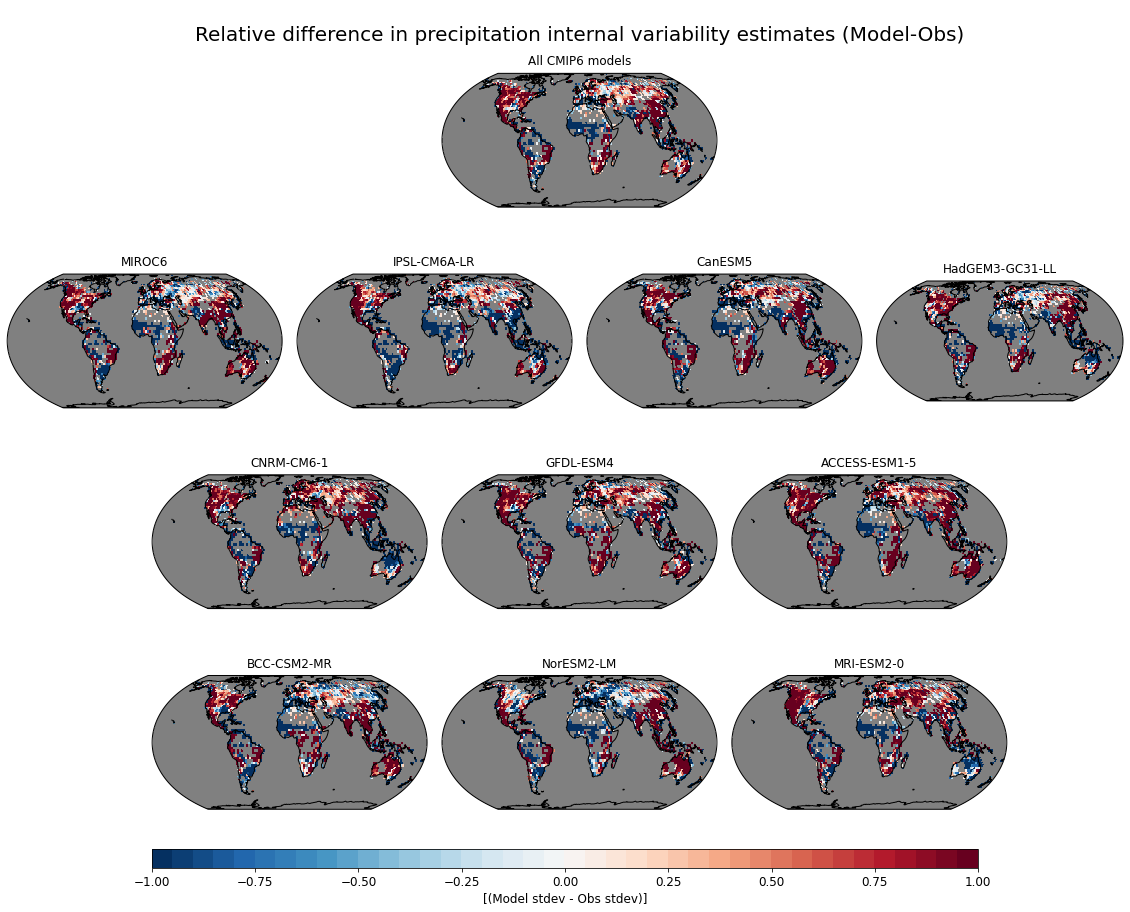

In [169]:
n_col = 4
n_row = 4

fig=plt.figure(figsize=(n_col*5, n_row * 4))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3+1, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

i=0
i_y=0

for i in range(len(models)+1):
    
    if i==0:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[model][key]),axis=0) for model in y_pi.keys() for key in y_pi[model].keys()])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 

        ax = plt.subplot(grid[i+1:i+3,(i_y+1)*10+5:(i_y+1)*10+15], projection=ccrs.EqualEarth())
        
    elif i<5:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]]])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 
        ax = plt.subplot(grid[4:6,i_y*10:i_y*10+10], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
    
    elif i>4:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]]])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 
        
        if (i-5)%3==0:
            i_y=0
            ax = plt.subplot(grid[i+2:i+4,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))

        else:
            ax = plt.subplot(grid[(i-5)-((i-5)%3)+7:(i-5)-((i-5)%3)+9,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
        
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, (mod_pi_var-gpcc_var), transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r',40), vmin=-1, vmax=1,rasterized=True)
    if i==0:
        ax.set_title("All CMIP6 models",y=1.02,fontsize=12)
    else:
        ax.set_title(models[i-1],y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)

axtitle = plt.subplot(grid[0,6:-5])
plt.title('Relative difference in precipitation internal variability estimates (Model-Obs)',fontsize=20,y=0.4)      
plt.axis('off') 

axcbar = plt.subplot(grid[-1:,5:-5])
cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)
cbar.set_label('[(Model stdev - Obs stdev)]')  
plt.axis('off') 



(0.0, 1.0, 0.0, 1.0)

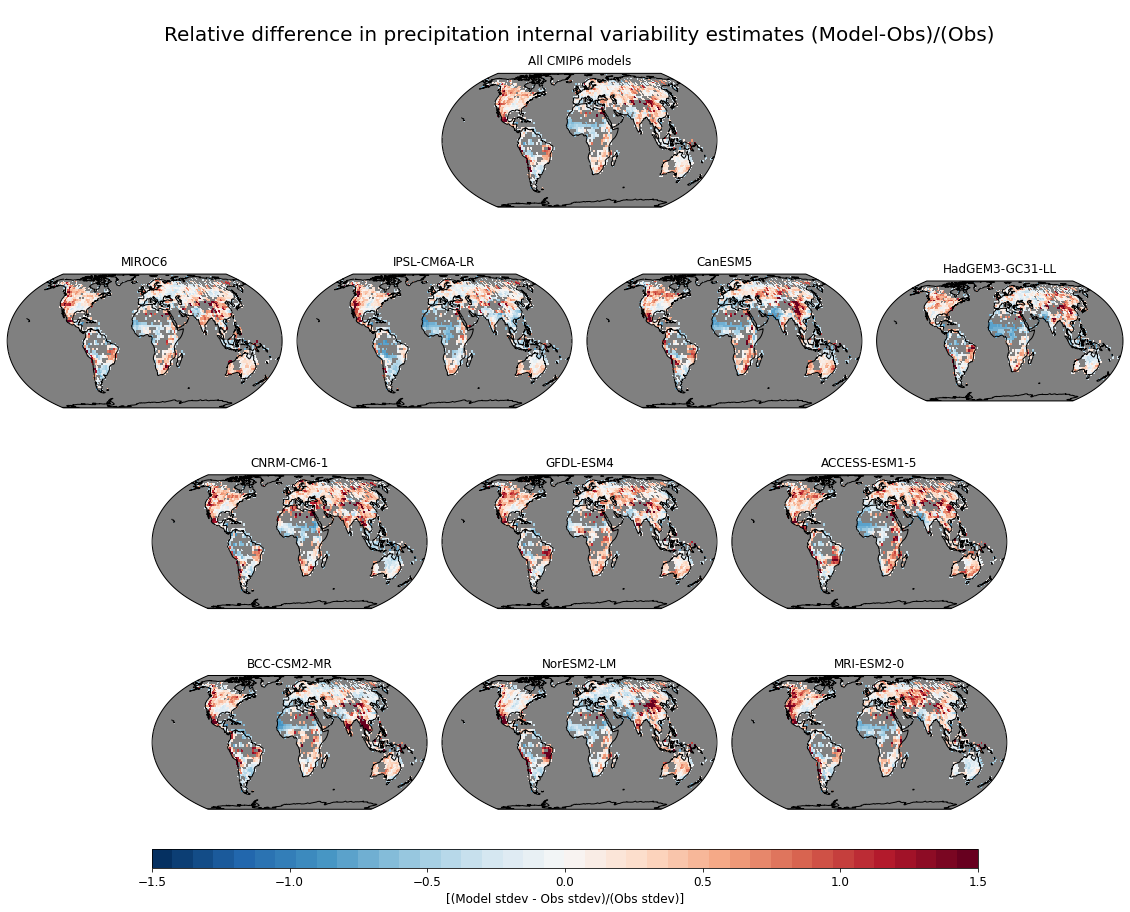

In [174]:
n_col = 4
n_row = 4

fig=plt.figure(figsize=(n_col*5, n_row * 4))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3+1, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

i=0
i_y=0

for i in range(len(models)+1):
    
    if i==0:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[model][key]),axis=0) for model in y_pi.keys() for key in y_pi[model].keys()])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 

        ax = plt.subplot(grid[i+1:i+3,(i_y+1)*10+5:(i_y+1)*10+15], projection=ccrs.EqualEarth())
        
    elif i<5:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]]])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 
        ax = plt.subplot(grid[4:6,i_y*10:i_y*10+10], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
    
    elif i>4:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]]])),axis=0)
        mod_pi_var[nan_mask_knut]=np.nan 
        
        if (i-5)%3==0:
            i_y=0
            ax = plt.subplot(grid[i+2:i+4,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))

        else:
            ax = plt.subplot(grid[(i-5)-((i-5)%3)+7:(i-5)-((i-5)%3)+9,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
        
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, (mod_pi_var-gpcc_var)/gpcc_var, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r',40), vmin=-1.5, vmax=1.5,rasterized=True)
    if i==0:
        ax.set_title("All CMIP6 models",y=1.02,fontsize=12)
    else:
        ax.set_title(models[i-1],y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)

axtitle = plt.subplot(grid[0,6:-5])
plt.title('Relative difference in precipitation internal variability estimates (Model-Obs)/(Obs)',fontsize=20,y=0.4)      
plt.axis('off') 

axcbar = plt.subplot(grid[-1:,5:-5])
cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)
cbar.set_label('[(Model stdev - Obs stdev)/(Obs stdev)]')  
plt.axis('off') 



In [ ]:
trend_2010_hn={}
trend_2010_af={}

resampled_trend_hn_2010={}
resampled_trend_af_2010={}

trend_2016_hn={}
trend_2016_af={}

resampled_trend_hn_2016={}
resampled_trend_af_2016={}

time={}

n_samples=50


obs_std=gpcc_var


for model in models:
    
    mod_std=np.mean(np.stack(([np.nanstd(butter(y_pi_mon[model][key]),axis=0) for key in y_pi[model]])),axis=0)

    std_corr=obs_std/mod_std
    
    
    print('Creating trend distribution for', model)
    time[model]=np.arange(1891,2018)
    
    trend_2010_hn[model]={}
    trend_2010_af[model]={}
    
    resampled_trend_hn_2010[model]={}
    resampled_trend_af_2010[model]={}

    trend_2016_hn[model]={}
    trend_2016_af[model]={}
    
    resampled_trend_hn_2016[model]={}
    resampled_trend_af_2016[model]={}
    

    for ref in [1951]:
        
        trend_2010_hn[model][ref]=mean_trend_from_dict(y_hn[model],time[model],ref,2010)
        trend_2016_hn[model][ref]=mean_trend_from_dict(y_hn[model],time[model],ref,2012)

        trend_2010_af[model][ref]=mean_trend_from_dict(y_af[model],time[model],ref,2010)
        trend_2016_af[model][ref]=mean_trend_from_dict(y_af[model],time[model],ref,2016)
    

        resampled_trend_hn_2010[model][ref]=np.zeros([n_samples,trend_2010_hn[model][ref].shape[0],
                                              trend_2010_hn[model][ref].shape[1]])

        resampled_trend_af_2010[model][ref]=np.zeros([n_samples,trend_2010_af[model][ref].shape[0],
                                              trend_2010_af[model][ref].shape[1]])
        
        resampled_trend_hn_2016[model][ref]=np.zeros([n_samples,trend_2016_hn[model][ref].shape[0],
                                              trend_2016_hn[model][ref].shape[1]])

        resampled_trend_af_2016[model][ref]=np.zeros([n_samples,trend_2016_af[model][ref].shape[0],
                                              trend_2016_af[model][ref].shape[1]])

   
        for sample in tqdm(range(n_samples)):

            start_pi=np.random.randint(0,y_pi_dc[model].shape[0]-(2016-ref))
            end_pi=start_pi+(2016-ref)

            
            resampled_trend_hn_2010[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)*std_corr)+trend_2010_hn[model][ref]
            resampled_trend_af_2010[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)*std_corr)+trend_2010_af[model][ref]
            
            resampled_trend_hn_2016[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)*std_corr)+trend_2016_hn[model][ref]
            resampled_trend_af_2016[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)*std_corr)+trend_2016_af[model][ref]
            

In [94]:
##get array of all models over period of interest, here we calculate mean trend over models 
#unlike for tas where it is the aggregate trend

for ref in ['mean']:
    
    resampled_trend_hn_2010[ref]=np.stack(([trend_2010_hn[mod][1951] for mod in models]))
    
    resampled_trend_af_2010[ref]=np.stack(([trend_2010_af[mod][1951] for mod in models]))
    
    resampled_trend_hn_2016[ref]=np.stack(([trend_2016_hn[mod][1951] for mod in models]))
    
    resampled_trend_af_2016[ref]=np.stack(([trend_2016_af[mod][1951] for mod in models]))

In [177]:
from scipy.stats import percentileofscore
import scipy
## need to find a more elegant method, this is quick and dirty

def attr_categorize(af_quantiles,hn_quantiles,obs_trend):
    try:
        sign=np.sign(obs_trend)
        loc_af=np.zeros(af_quantiles.shape[0])
        scale_af=np.zeros(af_quantiles.shape[0])
        loc_hn=np.zeros(hn_quantiles.shape[0])
        scale_hn=np.zeros(hn_quantiles.shape[0])

        for i in np.arange(af_quantiles.shape[0]):
            loc_af[i],scale_af[i]=scipy.stats.norm.fit(af_quantiles[i,:])
            loc_hn[i],scale_hn[i]=scipy.stats.norm.fit(hn_quantiles[i,:])


        loc_af=np.mean(loc_af)
        loc_hn=np.mean(loc_hn)
        scale_af=np.mean(scale_af)
        scale_hn=np.mean(scale_hn)


        #percentile_af=percentileofscore(af_quantiles,obs_trend)
        #percentile_hn=percentileofscore(hn_quantiles,obs_trend)
        percentile_af=scipy.stats.norm.cdf(obs_trend,loc_af,scale_af)*100
        percentile_hn=scipy.stats.norm.cdf(obs_trend,loc_hn,scale_hn)*100

        if sign==1:
            if percentile_af>5 and percentile_af<95:
                if percentile_hn<=96:
                    return 0
                else:
                    return 2
            elif (percentile_hn<95 and percentile_hn>5):
                return 0
            elif (percentile_af<=5 and percentile_hn>=95):
                return 1
            elif percentile_hn<=5:
                return 0
            elif percentile_af>=95:
                if np.sign(np.average(af_quantiles))!=sign:
                    if percentile_hn>5:
                        print(percentile_hn,percentile_af,np.average(af_quantiles))
                        return 4
                    else:
                        return 4
                else:
                    return 3

        elif sign==-1:

            if (percentile_af<95 and percentile_af>5):
                if percentile_hn>=4:
                    return 0
                else:
                    return -2
            elif (percentile_hn>5 and percentile_hn<95):
                return 0
            elif (percentile_hn<=5 and percentile_af>=95):
                return -1
            elif percentile_hn>=95:
                return 0
            elif percentile_af<=5:
                if np.sign(np.average(af_quantiles))!=sign:
                    if percentile_hn>5:
                        print(percentile_hn,percentile_af)
                        return -4
                    else:
                        return -4
                else:
                    return -3
    except:
        return np.nan


In [ ]:
## Assign attribution categories
ref=1951

attr_2010=np.full([72,144],np.nan)
attr_2016=np.full([72,144],np.nan)

x,y=np.meshgrid(np.arange(72),np.arange(144))

for i_x, i_y in zip(x.flatten(),y.flatten()):

                                          
    attr_2010[i_x,i_y]=attr_categorize(resampled_trend_af_2010[ref].reshape(10,-1,72,144)[:,:,i_x,i_y],
                                                         resampled_trend_hn_2010[ref].reshape(10,-1,72,144)[:,:,i_x,i_y],
                                            trend_2010_gpcc[1951].reshape(1,72,144)[:,i_x,i_y])

    attr_2016[i_x,i_y]=attr_categorize(resampled_trend_af_2016[ref].reshape(10,-1,72,144)[:,:,i_x,i_y],
                                                         resampled_trend_hn_2016[ref].reshape(10,-1,72,144)[:,:,i_x,i_y],
                                            trend_2016_gpcc[1951].reshape(1,72,144)[:,i_x,i_y])


(0.0, 1.0, 0.0, 1.0)

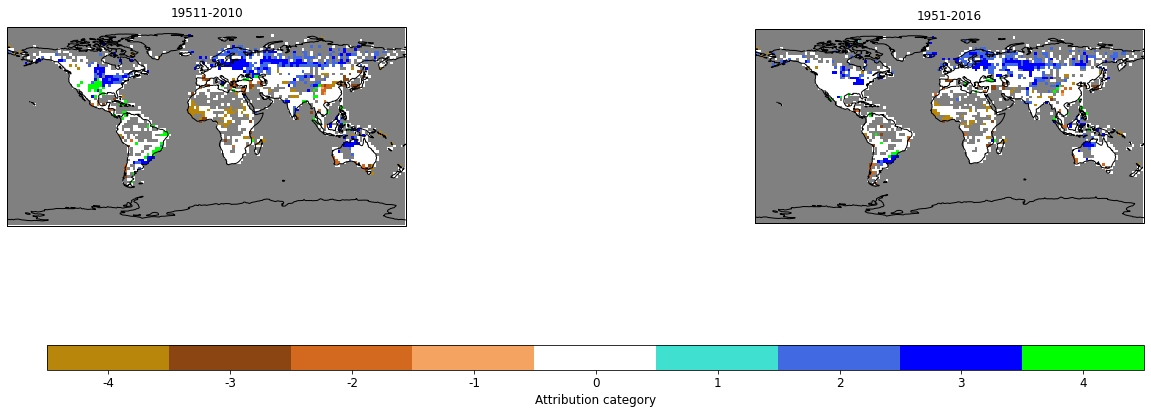

In [181]:
import matplotlib as mpl
n_col = 2
n_row = 3

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

cmap = mpl.colors.ListedColormap(['darkgoldenrod','saddlebrown','chocolate','sandybrown','white',
                                  'turquoise','royalblue','blue','lime'])

bounds = [ -4.5,-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5,4.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

i=0
for ref in [1951_1]:
    
    
    res_2010_plt=attr_2010
    
    res_2016_plt=attr_2016
    
    plt.title('Trend assessment using observation median values')
    i_y=0

    ax = plt.subplot(grid[i+1:i+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree())
    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, res_2010_plt, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,vmin=-5.5,rasterized=True)
    
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
    ax.set_title("%i-2010"%(ref),y=1.02,fontsize=12)
    
    i_y+=1
    i+=1

    ax = plt.subplot(grid[i-(i%2)+1:i-(i%2)+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree())

    i_y+=1
    i+=1
  
    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, res_2016_plt, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,vmin=-5.5,rasterized=True)
    
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
    ax.set_title("1951-2016",y=1.02,fontsize=12)
    
axcbar = plt.subplot(grid[i-(i%2):i-(i%2)+1,5:25])
cbar=plt.colorbar(mesh_1,orientation='horizontal',ticks=[-4,-3,-2,-1,0,1,2,3,4],fraction=0.4,aspect=45)
cbar.set_label('Attribution category')
cbar.ax.set_xlim(-4.5,4.5)
cbar.ax.set_xticklabels(np.arange(-4,5))
plt.axis('off')   


In [182]:
df_attr=xr.Dataset(
    {
        "Attribution_Category_2016": (["latitude", "longitude"],attr_2016),
        "Attribution_Category_2010": (["latitude", "longitude"],attr_2010)
    },
    coords={
        "longitude": (["longitude"], lon),
        "latitude": (["latitude"], lat),
    },
)

df_attr.to_netcdf('precip_adj_attribution_categories_g05_centred_v2.nc')

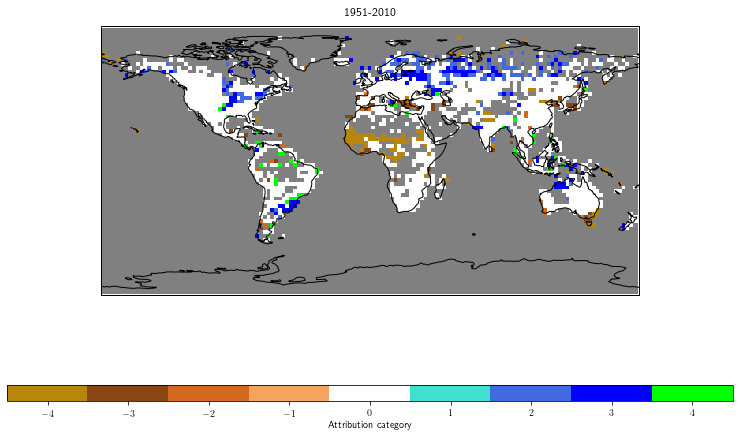

In [17]:
import matplotlib as mpl
n_col = 1
n_row = 1

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})


grid = plt.GridSpec(1, 1, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

cmap = mpl.colors.ListedColormap(['darkgoldenrod','saddlebrown','chocolate','sandybrown','white',
                                  'turquoise','royalblue','blue','lime'])

bounds = [ -4.5,-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5,4.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

i=0
for ref in [1951]:
   
    
    ax = plt.subplot(grid[0,0], projection=ccrs.PlateCarree(central_longitude=0))
   
    res_2010_plt=df_attr.Attribution_Category_2010.values
    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, res_2010_plt, transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,norm=norm,vmin=-4.5,rasterized=True)
    ax.set_title("%i-2010"%(ref),y=1.02,fontsize=12)
    
    plt.colorbar(mesh_1,orientation='horizontal',ticks=[-4,-3,-2,-1,0,1,2,3,4],fraction=0.4,aspect=45,extend='neither',label='Attribution category')
    
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
   


In [38]:
## save functions to access in temperature notebook

np.save('trend_1951_2016_gpcc.npy',trend_2016_gpcc[ref])
np.save('trend_1951_2016_af.npy',np.mean(resampled_trend_af_2016[ref].reshape(-1,72,144),axis=0))